In [1]:
import os
import sys
sys.path.insert(0, os.path.dirname(os.getcwd()))
#sys.path.insert(0, "/Users/mothp/Python_codes/Nerii-4/")
sys.path.insert(0, "/Users/mothp/Python_codes/Nerii-4/archeo/")

from PIL import Image
import numpy as np
import random
import pickle
from scipy.stats import wasserstein_distance
from tqdm import tqdm as tqdm
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 12})
from matplotlib.cm import get_cmap
from collections import Counter
import copy

from archeo.utils import *
from archeo.encoders.mario_lvl_encoder import MarioLvlEncoder
#from archeo.encoders.roblox_lvl_encoder import RobloxLvlEncoder
from archeo.mappings.sequence_mapping import SequenceMapping
sys.path.insert(0, "/Users/mothp/Python_codes/Nerii-4/")
from Measurements_suite import MeasurementsSuite

# Preamble

In [2]:
def count_consecutive_sequences(lst, L):
    if L <= 0:
        raise ValueError("Size L must be a positive integer.")

    if L > len(lst):
        return {}

    # Create all consecutive sequences of size L
    sequences = [tuple(lst[i:i + L]) for i in range(len(lst) - L + 1)]

    # Use Counter to count the occurrences of each sequence
    return dict(Counter(sequences))
    
def most_repeated_ratio(lst):
    if not lst:  # Check for an empty list
        return 0
    freq = Counter(lst)
    max_repeated = max(freq.values())
    ratio = max_repeated / len(lst)
    
    return ratio
    
def originality_rate(list_generated, original, max_l):
    originality = {}
    for L in range(2,max_l+1):
        originality_counts = []
        sequence_counts = []
        
        # Count consecutive sequences for both sequences
        original_counts = count_consecutive_sequences(original, L)
    
        for generated in list_generated:
            generated_counts = count_consecutive_sequences(generated, L)
            
            # Compute ratios for keys in the original dictionary
            for seq,count in generated_counts.items():
                if seq not in original_counts:
                    originality_counts.append(count)  # Avoid division by zero
    
                sequence_counts.append(count)
        originality_ratio = np.sum(originality_counts)/np.sum(sequence_counts)

        originality[L] = originality_ratio
    return originality

def get_probs(sequence,featnum):
    sequence = list(sequence)
    # probability of each feature
    probs = {}
    for feat in range(featnum):
        probs[feat] = sequence.count(feat)/len(sequence)
    return probs

def get_markov_probs(sequence,featnum):
    # probability of each feature given previous feature
    markov_probs = {feat:[] for feat in range(featnum)}
    for f in range(len(sequence)):
        markov_probs[sequence[f]].append(sequence[(f+1)%len(sequence)])
    for feat0 in range(featnum):
        mprob = {}
        for feat1 in markov_probs[feat0]:
            mprob[feat1] = markov_probs[feat0].count(feat1)/len(markov_probs[feat0])
        markov_probs[feat0] = mprob
    return markov_probs


def generate_markov_sequence(probs, markov_probs,length):
    markov_sequence = random.choices(list(probs.keys()), weights=probs.values(), k=1)
    for _ in range(length-1):
        markov_sequence += random.choices(
            list(markov_probs[markov_sequence[-1]].keys()),
            weights=markov_probs[markov_sequence[-1]].values(),
            k=1
        )
    return markov_sequence

def generate_uncorrelated_sequence(probs,length):
    return random.choices(list(probs.keys()), weights=probs.values(), k=length)

def find_broken_rules(sequence,rules,res=None):
    if res == None:
        res = {}
        
    for i,feat in enumerate(sequence):
        has_rule, respect_rule, rule_name = rules(i,sequence)
        if has_rule and respect_rule:
            res[rule_name] = np.array([1,0]) + res.get(rule_name,np.array([0,0]))
        elif has_rule and not respect_rule:
            res[rule_name] = np.array([1,1]) + res.get(rule_name,np.array([0,0]))

    return res

def separation_stats(lst, j):
    if isinstance(lst[0],list) or isinstance(lst[0],np.ndarray):
        average=[]
        std=[]
        for l in lst:
            m,s = separation_stats(l,j)
            average.append(m)
            std.append(s)
        return np.nanmean(average),np.nanstd(std)
    
    indices = [i for i, x in enumerate(lst) if x == j]
    if len(indices) < 2:
        return np.nan,np.nan  # Not enough occurrences to calculate separations
    
    separations = np.diff(indices)
    mean_separation = np.mean(separations)
    std_separation = np.std(separations)
    
    return mean_separation, std_separation

def entropy(probs):
    ent = 0
    for f in probs:
        ent -= probs[f]*np.log(probs[f])/np.log(2)
    return ent

def markov_entropy(markov_probs,probs):
    ent = 0
    for f in probs:
        for ff in markov_probs[f]:
            ent -= probs[f]*markov_probs[f][ff]*np.log(markov_probs[f][ff])/np.log(2)
    return ent


# Roblox analysis

We start by loading a level that we created ourselves which includes 2 ball sequences and saving points every 16 features.

In [ ]:
level = '6'
level_path = 'Data/Roblox/original_levels/'+level+'.png'
pic = Image.open(level_path)

encoder = RobloxLvlEncoder({"unit":8})
mapping = SequenceMapping()

encoded_seq = encoder.encode(encoder.read(level_path))
mapping.get_mapping(encoded_seq[0])

sequence = mapping.map(encoded_seq[0])

pic

The level is translated to a sequence of integers representing an unique feature

In [ ]:
length = len(sequence)

featnum = mapping.vocab_size
print("Number of unique columns:", featnum)

print('\nSequence of features in level:')
print(sequence)

In [ ]:
def sequence2pic(sequence,save=False, filename=None):
    pic = encoder.decode([mapping.unmap(sequence)])
 
    if save and filename:
        pic.save("./Figures/"+filename+".png")
        print(f"Image saved as '{filename}'")
    
    return pic

print('\nSequence of all features in order:')
sequence2pic(list(range(featnum)))

And manually write down the possible broken transitions

In [578]:
def roblox_rules(i,arr):
    has_rule = True
    respect_rule = False
    feat = arr[i]
    rule_name = None

    ball_seq = np.array([27, 28, 26, 28, 28, 5])
    
    lseq = len(ball_seq)
    larr = len(arr)
    try:
        if feat == 27 and i+lseq <= larr: 
            respect_rule = (arr[i:i+lseq] == ball_seq).all()
            rule_name = "ball"
        elif feat == 26 and i-2+lseq <= larr and i-2 >= 0: 
            respect_rule = (arr[i-2:i-2+lseq] == ball_seq).all()
            rule_name = "ball"
        elif feat == 5 and i-5+lseq <= larr and i-5 >= 0: 
            respect_rule = (arr[i-5:i-5+lseq] == ball_seq).all()
            rule_name = "ball"
        elif feat == 6:
            respect_rule = (arr[i-1]==5)
            rule_name = "jump"
        else:
            has_rule = False
            
    except IndexError:
        has_rule = False
        
    return has_rule, respect_rule, rule_name


We can load the previsouly generated data:

In [579]:
Sequences = {}

In [580]:
beta_list = [1,2,3]
qubit_list = [4,5,6,7,8]
# retrieve previously generated levels
Sequences["QRC_Aer"]={}

for n_qubits in qubit_list:
    for beta in beta_list:
    	filename = os.path.join(f'Data/Roblox/{n_qubits}_qubits/Aer/Sequences_level_{level}_beta_{beta}_Aer.p')
    	with open(filename, 'rb') as file:
    		Sequences["QRC_Aer"][(beta,n_qubits)] = pickle.load(file)

This is how a typical level looks like

In [ ]:
unique_sequences = random.sample(Sequences["QRC_Aer"][(1,6)], 1)
for seq in unique_sequences:
    display(sequence2pic(seq))

We can also generate samples with a Markov chain or a uncorrelated generator

In [538]:
n_samples = 1000
reference_measurements = MeasurementsSuite(data=sequence,original=sequence)
probs = reference_measurements.probs
markov_probs = reference_measurements.markov_probs

Sequences["Markov"] = [reference_measurements.generate_markov_sequence(sequence,tot_length) for _ in range(n_samples)]
Sequences["Uncorr"] = [reference_measurements.generate_uncorrelated_sequence(sequence,tot_length) for _ in range(n_samples)]


And run the analysis on the generated data

In [539]:
def to_rate(dic):
    errors = list(dic.keys())
    errors.sort()
    rate = [dic[e][1]/dic[e][0] for e in errors]
    return [errors,rate]

def originality(seqs):
    return originality_rate(seqs,sequence,max_l = 20)

def mistakes_ball(seqs):
    n_sample = len(seqs)
    brules={}
    rep = []
    for n in range(n_sample):
        find_broken_rules(seqs[n],roblox_rules,brules)
    return to_rate(brules)[1][0]


We can look at the originality for different temperatures and decide to stick with T=1

In [ ]:

cmap = plt.colormaps.get_cmap("coolwarm")
colors = [cmap(i) for i in np.linspace(0, 1, )] 

beta_list = [1,2,3]

for i,b in enumerate(beta_list):
    color = cmap(i/5)
    orig = originality_rate(Sequences["QRC_Aer"][(b,7)],sequence,max_l = 20)
    plt.plot(orig.keys(),orig.values(),'o-',label="Aer $T="+str(b)+"$",color=color)

orig = originality_rate(Sequences["Markov"],sequence,max_l = 20)
plt.plot(orig.keys(),orig.values(),'--',label="Markov",color="k")

orig = originality_rate(Sequences["Uncorr"],sequence,max_l = 20)
plt.plot(orig.keys(),orig.values(),'-.',label="Uncorr.",color="k")

plt.xticks([2,4,6,8,10,12,14,16,18,20])
plt.legend()
plt.ylabel("Originality rate")
plt.xlabel("Sequence length")
plt.savefig("./Figures/originality_roblox_T.png",dpi=300)
plt.show()

We can take a look at the separation metrics

In [ ]:
print("Aer")
for q in qubit_list:
    print(f"{q}: {separation_stats(Sequences["QRC_Aer"][(1,q)],11)}")
print(f"Markov: {separation_stats(Sequences["Markov"],11)}")
print(f"Uncorr: {separation_stats(Sequences["Uncorr"],11)}")
print(f"Original: {separation_stats(sequence,11)}")

An the originality for different number of qubits

In [ ]:
cmap = plt.colormaps.get_cmap("summer")
colors = [cmap(i) for i in np.linspace(0, 1, )] 
beta = 1
q_list = [4,5,6,7,8]

for i,q in enumerate(q_list):
    color = cmap(i/4)
    orig = originality_rate(Sequences["QRC_Aer"][(beta,q)],sequence,max_l = 20)
    plt.plot(orig.keys(),orig.values(),'o-',label="QRC $q="+str(q)+"$",color=color)

orig = originality_rate(Sequences["Markov"],sequence,max_l = 20)
plt.plot(orig.keys(),orig.values(),'--',label="Markov",color="k")

orig = originality_rate(Sequences["Uncorr"],sequence,max_l = 20)
plt.plot(orig.keys(),orig.values(),'-.',label="Uncorr.",color="k")

plt.xticks(range(2,22)[::2])
plt.legend()
plt.ylabel("Originality rate")
plt.xlabel("Sequence length")
plt.savefig("./Figures/originality_roblox.png")
plt.show()

as well as the error rate

In [ ]:
images =  [Image.open("./Figures/ball_error"+str(i)+".png") for i in range(1,3)]
img_width, img_height = images[0].size
scale = 0.4


fig, ax1 = plt.subplots()

beta = 1
q_list = [4,5,6,7,8]
mst = [mistakes_ball(Sequences["QRC_Aer"][(beta,q)]) for q in q_list]
ax1.plot(q_list,mst,'o-',color="green",label="QRC")

mst_markov = [mistakes_ball(Sequences["Markov"]) for q in q_list]
ax1.plot(q_list,mst_markov,'--',color="black",label="Markov")

for i,image in enumerate(images):
    inset = fig.add_axes([0.5 , 0.6+ i*0.1, scale,scale* img_height/img_width])
    inset.imshow(image)
    plt.setp(inset, xticks=[], yticks=[])

#ax1.set_yscale("log")
ax1.set_ylabel("Rate of broken sequences")
ax1.set_xlabel("Number of qubits")
ax1.legend()
ax1.set_xticks([4,5,6,7,8])
plt.savefig("./Figures/roblox_errors.png",dpi=300)

plt.show()

# Mario analysis

First choose a game level. Currently we have 1-2 from Super Mario Bros.

Log set to: False
Log set to: False


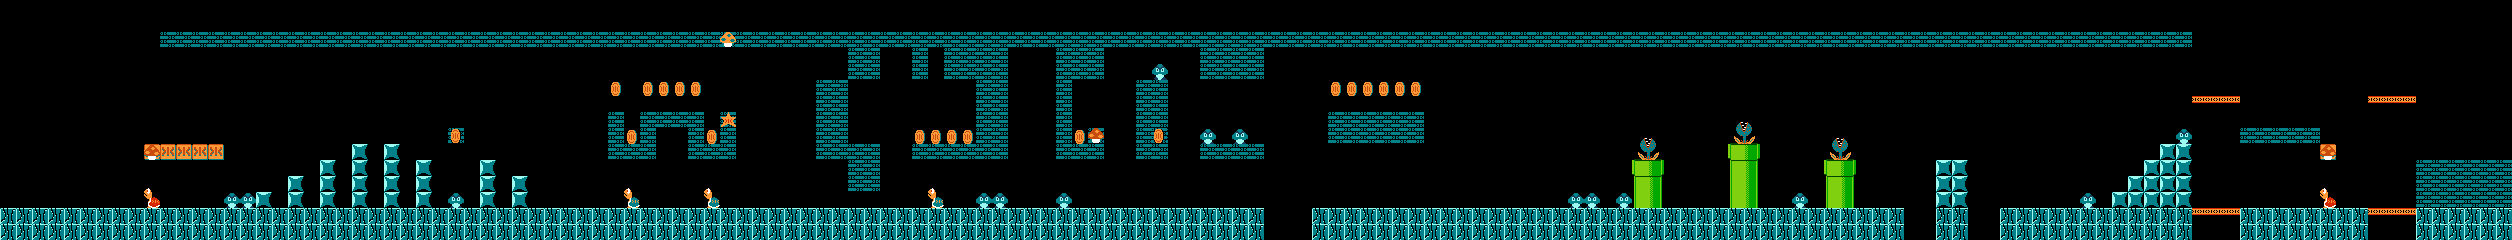

In [21]:
level = '1-2'
level_path = 'Data/SMB/original_levels/'+level+'-moth.png'
pic = Image.open(level_path)

encoder = MarioLvlEncoder({"rows":1,"unit":16})
mapping = SequenceMapping()

encoded_seq = encoder.encode(encoder.read(level_path))
mapping.get_mapping(encoded_seq[0])

sequence = mapping.map(encoded_seq[0])

def export(seq,path):
    enc = encoder.decode([mapping.unmap(seq)])
    encoder.write(path,enc)
pic

This level will now be split into columns one block wide. Each unique column will be regarded as a separate feature. The original levels were modified to get them down to 32 features per level.

In [22]:
length = len(sequence)

featnum = mapping.vocab_size
print("Number of unique columns:", featnum)
print("Length of level:", length)
print('\nSequence of features in level:')
print(sequence)

Number of unique columns: 32
Length of level: 157

Sequence of features in level:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 11, 11, 11, 11, 7, 7, 8, 6, 9, 6, 10, 6, 12, 6, 12, 6, 10, 6, 17, 6, 10, 6, 9, 6, 6, 6, 6, 6, 22, 15, 22, 20, 20, 22, 15, 31, 6, 6, 6, 6, 6, 23, 23, 26, 26, 6, 6, 27, 15, 27, 27, 30, 30, 6, 6, 6, 30, 27, 29, 6, 6, 23, 24, 6, 6, 28, 25, 28, 25, 5, 5, 5, 6, 21, 21, 21, 21, 21, 21, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 6, 7, 13, 14, 6, 6, 6, 6, 18, 19, 6, 6, 7, 6, 13, 14, 6, 6, 6, 5, 5, 10, 10, 5, 5, 6, 6, 6, 6, 6, 7, 6, 8, 9, 10, 12, 16, 4, 4, 4, 3, 3, 3, 3, 3, 2, 0, 0, 4, 4, 4, 1, 1, 1, 1, 1, 1]



Sequence of all features in order:


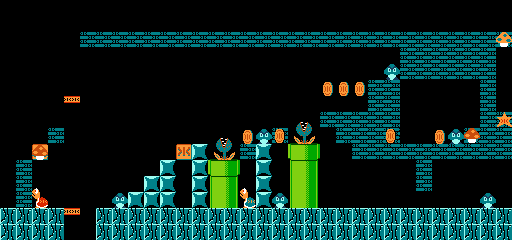

In [23]:
def sequence2pic(sequence,save=False, filename=None):
    pic = encoder.decode([mapping.unmap(sequence)])
 
    if save and filename:
        pic.save("./Figures/"+filename+".png")
        print(f"Image saved as '{filename}'")
    
    return pic

print('\nSequence of all features in order:')
sequence2pic(list(range(featnum)))

Next we will identify some game breaking sequences and write them as a set of rules. Some rules are directly imposed like having the two sides of the pipe connected, others are indirectly imposed like never blocking passage.

In [24]:
def mario_rules(i,arr):
    has_rule = True
    respect_rule = False
    feat = arr[i]
    rule_name = ""

    try:
        if level == "1-2" and i>0 and i<len(arr):
            if feat == 14: #Checks if the right part of the small tub follows the left
                respect_rule = (arr[i-1] == 13)
                rule_name = "2"
            elif feat == 13: #Checks if the left part of the small tub preceeds the right
                respect_rule = (arr[i+1] == 14)
                rule_name = "2"
            elif feat == 19: #Checks if the right part of the large tub follows the left
                respect_rule = (arr[i-1] == 18)
                rule_name = "2"
            elif feat == 18: #Checks if the left part of the large tub preceeds the right
                respect_rule = (arr[i+1] == 19)
                rule_name = "2"
            elif feat == 30: #Checks that the passage is not blocked
                respect_rule = all((arr[i+1] != f) and (arr[i-1] != f) for f in [1,10,12,16,18,19] )
                rule_name = "2"
            elif feat == 16: #Checks that the coin is not blocked
                respect_rule = (arr[i-1] != 17) and (arr[i+1] != 17)
                rule_name = "3"
            elif feat == 14: #Checks that the passage is possible
                respect_rule = (arr[i-1] != 17) and ((arr[i+1] != 26) and (arr[i+1] != 28))
                respect_rule2 = (arr[i+1] != 17) and ((arr[i-1] != 26) and (arr[i-1] != 28))
                respect_rule = respect_rule and respect_rule2
                rule_name = "3"
            elif feat == 10: #Checks that the passage is possible
                respect_rule = (arr[i-1] != 17) and (arr[i+1] != 26) and (arr[i+1] != 28)
                respect_rule2 = (arr[i+1] != 17) and (arr[i-1] != 26) and (arr[i-1] != 28)
                respect_rule = respect_rule and respect_rule2
                rule_name = "3"
            else:
                has_rule = False
        else:
            has_rule = False
    except IndexError:
        has_rule = False
        
    return has_rule, respect_rule, rule_name


Now let's load the previously generated sequences:

In [25]:
Sequences={}

In [26]:
n_qubits = 6

In [42]:
beta_list = [0.001,.01,0.1,0.7,1,1.5,2,3,5,10,30]
# retrieve previously generated levels
Sequences["QRC_Aer"]={}
for beta in beta_list:
	filename = os.path.join(f'Data/SMB/{n_qubits}_qubits/Aer/Sequences_level_{level}_beta_{beta}_Aer.p')
	with open(filename, 'rb') as file:
		Sequences["QRC_Aer"][beta] = pickle.load(file)

In [28]:
beta_list = [0.01,0.1,0.7,1,3,10]
prob_list = [0, 0.01, 0.05, 0.3]
# retrieve previously generated levels
Sequences["QRC_FakeJames"]={}
for prob in prob_list:
    for beta in beta_list:
        filename = os.path.join(f'Data/SMB/{n_qubits}_qubits/FakeJames/Sequences_level_{level}_beta_{beta}_prob_{prob}_FakeJames.p')
        with open(filename, 'rb') as file:
            Sequences["QRC_FakeJames"][(prob,beta)] = pickle.load(file)

In [31]:
beta_list = [0.01,0.1,0.7,1,3,10]
# retrieve previously generated levels
Sequences["QRC_FakeGarnet"]={}
for beta in beta_list:
    filename = os.path.join(f'Data/SMB/{n_qubits}_qubits/FakeGarnet/Sequences_level_{level}_beta_{beta}_FakeGarnet.p')
    with open(filename, 'rb') as file:
        Sequences["QRC_FakeGarnet"][beta] = pickle.load(file)

In [32]:
beta_list = [0.01,0.1,0.7,1,1.5,2,3,10]
# retrieve previously generated levels
Sequences["QRC_Matrix"]={}
for beta in beta_list:
	filename = os.path.join(f'Data/SMB/{n_qubits}_qubits/Aer_matrixnoise/Sequences_level_{level}_beta_{beta}_Aer_matrixnoise.p')
	with open(filename, 'rb') as file:
		Sequences["QRC_Matrix"][beta] = pickle.load(file)

Here are 3 QRC generated samples for T=2

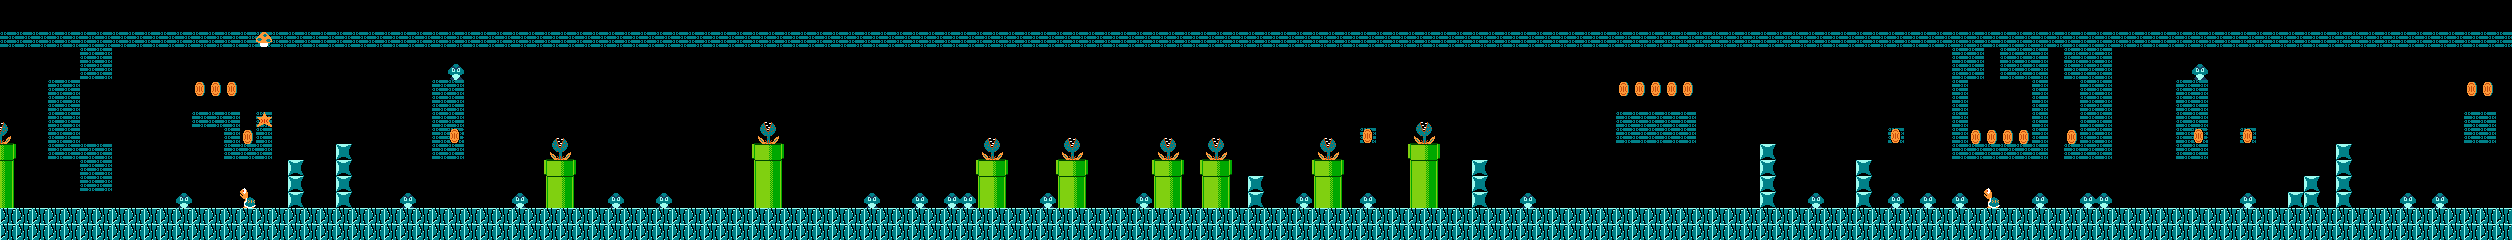

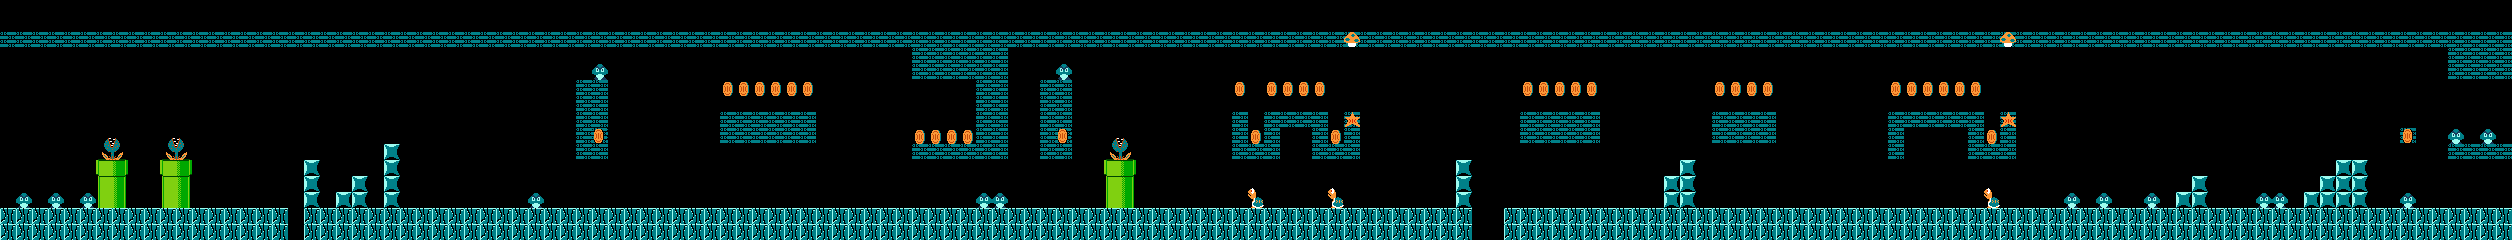

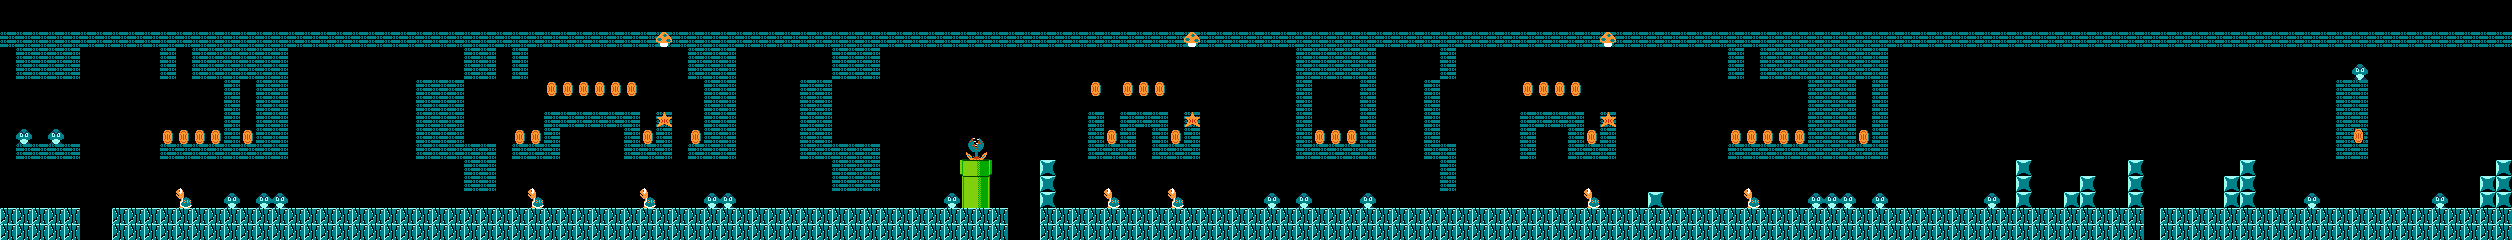

In [33]:
unique_sequences = random.sample(Sequences["QRC_FakeGarnet"][0.7], 3)
for seq in unique_sequences:
    display(sequence2pic(seq))

Alternatively we could have generated features randomly according to the frequencies at which they appear in the original, or according to a Markov chain. To test these options, we'll calculate the probabilities and generate the samples

In [34]:
n_samples = 1000
tot_length = 157

reference_measurements = MeasurementsSuite(data=sequence,original=sequence)
probs = reference_measurements.probs
markov_probs = reference_measurements.markov_probs

Sequences["Markov"] = [reference_measurements.generate_markov_sequence(sequence,tot_length) for _ in range(n_samples)]
Sequences["Uncorr"] = [reference_measurements.generate_uncorrelated_sequence(sequence,tot_length) for _ in range(n_samples)]


Here's a random sample generated when sampling in an uncorrelated way.

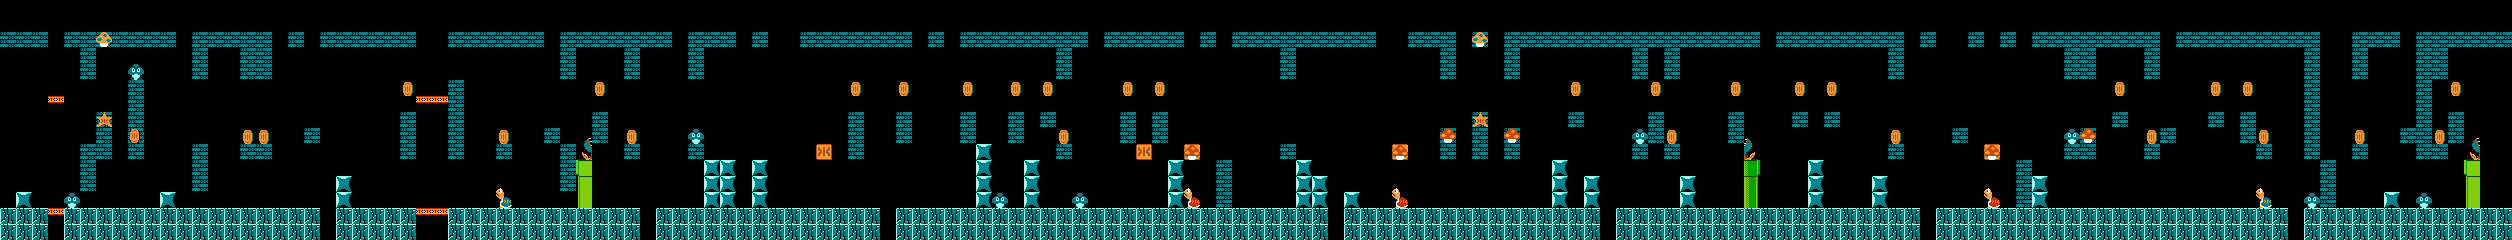

In [35]:
unique_sequences = random.sample(Sequences["Uncorr"], 1)
for seq in unique_sequences:
    display(sequence2pic(seq))

Here's one generated by a Markov chain.

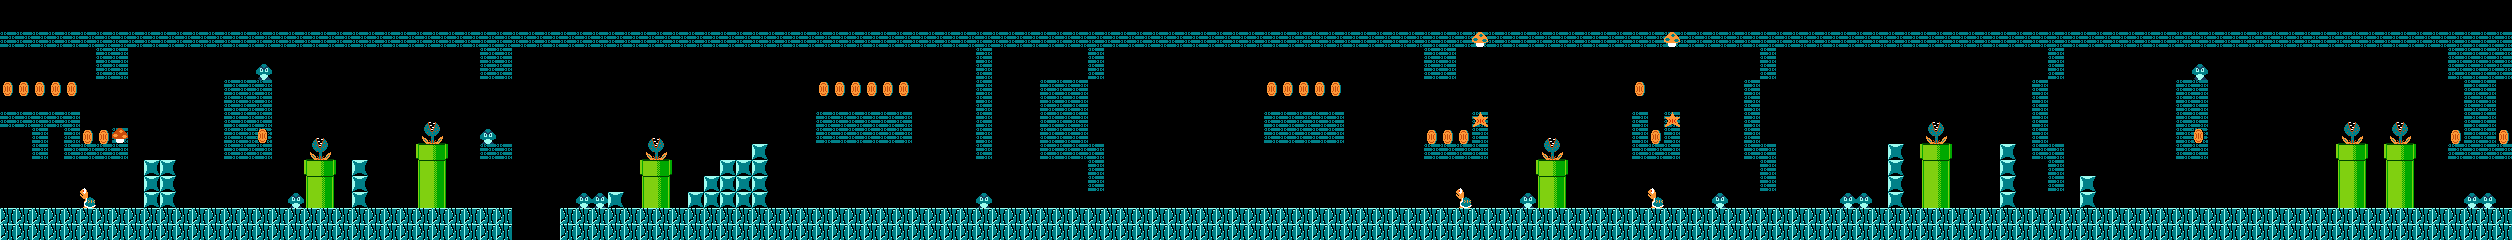

In [36]:
unique_sequences = random.sample(Sequences["Markov"], 1)
for seq in unique_sequences:
    display(sequence2pic(seq))

We run the two analysis methods described in the paper and compare the QRC-generated samples to ones generated by the other methods.

In [50]:
def to_rate(dic):
    errors = list(dic.keys())
    errors.sort()
    rate = [dic[e][1]/dic[e][0] for e in errors]
    return [errors,rate]

def originality(seqs):
    return originality_rate(seqs,sequence,max_l = 20)

def mistakes2(seqs):
    n_sample = len(seqs)
    brules={}
    rep = []
    for n in range(n_sample):
        find_broken_rules(seqs[n],mario_rules,brules)
    return to_rate(brules)[1][0]
        

We can plot the originality rate for different temperatures

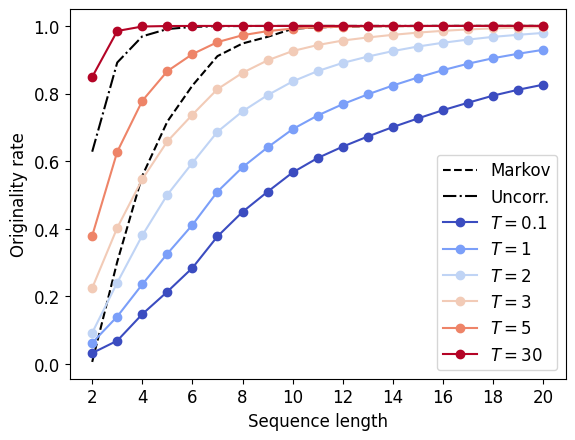

In [38]:

cmap = plt.colormaps.get_cmap("coolwarm")
colors = [cmap(i) for i in np.linspace(0, 1, )] 

beta_list = [0.1,1,2,3,5,30]

orig = originality_rate(Sequences["Markov"],sequence,max_l = 20)
plt.plot(orig.keys(),orig.values(),'--',label="Markov",color="k")

orig = originality_rate(Sequences["Uncorr"],sequence,max_l = 20)
plt.plot(orig.keys(),orig.values(),'-.',label="Uncorr.",color="k")

for i,b in enumerate(beta_list):
    color = cmap(i/5)
    orig = originality_rate(Sequences["QRC_Aer"][b],sequence,max_l = 20)
    plt.plot(orig.keys(),orig.values(),'o-',label="$T="+str(b)+"$",color=color)


plt.xticks([2,4,6,8,10,12,14,16,18,20])
plt.legend()
plt.ylabel("Originality rate")
plt.xlabel("Sequence length")
plt.savefig("./Figures/originality.png",dpi=300)
plt.show()

As well as the originality for different noise models:

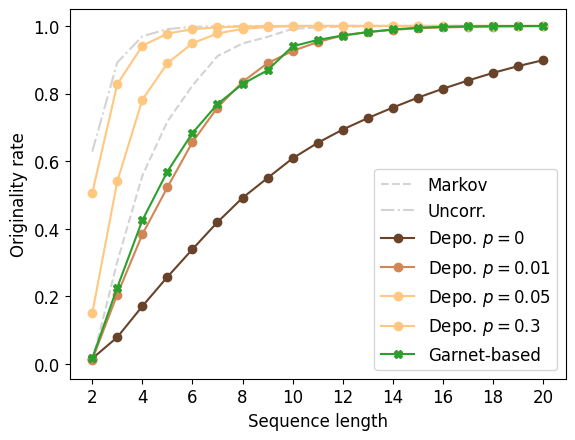

In [39]:

cmap = plt.colormaps.get_cmap("copper")
colors = [cmap(i) for i in np.linspace(0, 1, )] 

beta = 1

orig = originality_rate(Sequences["Markov"],sequence,max_l = 20)
plt.plot(orig.keys(),orig.values(),'--',label="Markov",color="lightgray")

orig = originality_rate(Sequences["Uncorr"],sequence,max_l = 20)
plt.plot(orig.keys(),orig.values(),'-.',label="Uncorr.",color="lightgray")

#orig = originality_rate(Sequences["QRC_Aer"][beta],sequence,max_l = 20)
#plt.plot(orig.keys(),orig.values(),'o-',label="Depo. $p=0$",color=cmap(0))

prob_list = [0, 0.01, 0.05, 0.3]
for i,p in enumerate(prob_list):
    color = cmap(i/3 + 1/3)
    orig = originality_rate(Sequences["QRC_FakeJames"][(p,beta)],sequence,max_l = 20)
    plt.plot(orig.keys(),orig.values(),'o-',label="Depo. $p="+str(p)+"$",color=color)

orig = originality_rate(Sequences["QRC_FakeGarnet"][beta],sequence,max_l = 20)
plt.plot(orig.keys(),orig.values(),'X-',label="Garnet-based",color="tab:green")


#orig = originality_rate(Sequences["QRC_Matrix"][beta],sequence,max_l = 20)
#plt.plot(orig.keys(),orig.values(),'X-',label="Matrix",color="tab:green")

plt.xticks([2,4,6,8,10,12,14,16,18,20])
plt.legend()
plt.ylabel("Originality rate")
plt.xlabel("Sequence length")
plt.savefig("./Figures/originality_noise.png",dpi=300)
plt.show()

as well as the rate of finding broken transitions

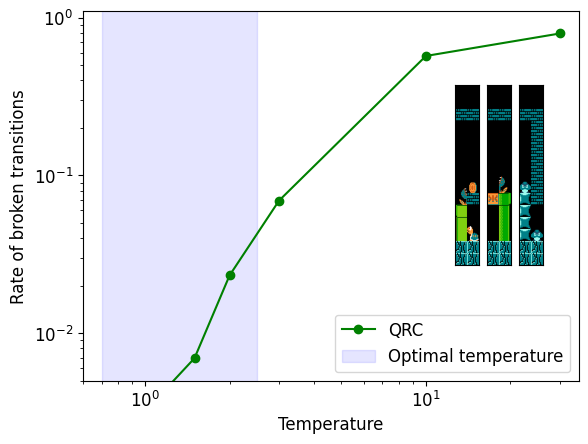

In [51]:

images =  [Image.open("./Figures/error2-"+str(i)+".png") for i in range(1,4)]
img_width, img_height = images[0].size
scale = 0.05

fig, ax1 = plt.subplots()

beta_list = [0.01,0.1,0.7,1,1.5,2,3,10,30]
#beta_list = [0.01,0.1,0.7,1,3,10]
mst = [mistakes2(Sequences["QRC_Aer"][b]) for b in beta_list]
ax1.plot(beta_list,mst,'o-',color="green",label="QRC")

for i,image in enumerate(images):
    inset = fig.add_axes([0.7 + i*scale, 0.35, scale,scale* img_height/img_width])
    inset.imshow(image)
    plt.setp(inset, xticks=[], yticks=[])

ax1.fill_betweenx(
    y=np.linspace(-1, 2, 100),  # Vertical range of the shaded region
    x1=0.7,  # Left boundary
    x2=2.5,  # Right boundary
    color="blue",
    alpha=0.1,  # Transparency
    label="Optimal temperature"
)
ax1.set_ylim((0.005,1.1))
ax1.set_xlim((0.6,35))
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_ylabel("Rate of broken transitions")
ax1.set_xlabel("Temperature")
ax1.legend()
plt.savefig("./Figures/errors.png",dpi=300)

plt.show()

Finally to export you rown sequences you only need to:

In [435]:
export([13,15],"Figures/error2-1.png")
export([11,19],"Figures/error2-2.png")
export([16,30],"Figures/error2-3.png")

In [440]:
export(sequence,"Figures/original_level.png")

In [452]:
export(random.sample(Sequences["QRC_Aer"][1], 1)[0],"Figures/aer_t1_level.png")

In [464]:
export(random.sample(Sequences["QRC_Aer"][0.01], 1)[0][:78],"Figures/aer_t001_level.png")

In [465]:
export(random.sample(Sequences["QRC_Aer"][10], 1)[0][:78],"Figures/aer_t10_level.png")

In [41]:
export(random.sample(Sequences["QRC_FakeGarnet"][1], 1)[0],"Figures/garnet_t1_level.png")